In [1]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

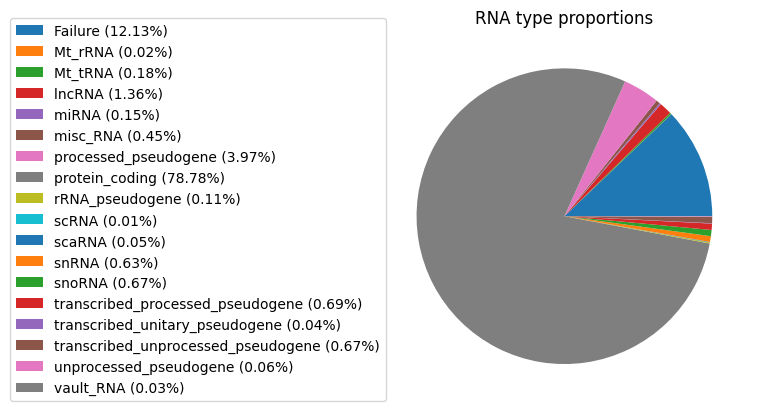

18 miRNA 
9376 protein coding mRNA


,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
MIR100,0,5,0,0,1,0,0,0,0,2,...,3,0,4,2,105,0,0,0,0,0
MIR103A2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62
MIR16-2,0,0,0,0,0,0,0,0,0,0,...,66,0,10,3,39,0,29,0,0,0
MIR199A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
MIR199A2,1,0,1,0,0,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
MIR221,19,0,0,0,13,0,0,0,0,0,...,0,0,0,0,51,0,2,0,0,0
MIR222,37,16,1,7,18,3,1,25,15,19,...,44,5,39,8,43,1,3,2,6,2
MIR23A,0,7,0,0,2,0,0,4,0,1,...,10,0,6,0,437,0,1,0,3,1
MIR24-2,0,2,0,0,0,0,0,0,2,0,...,3,0,12,12,28,0,0,1,1,0
MIR27A,0,5,0,0,6,2,6,10,3,1,...,0,0,1,0,0,0,0,0,1,0


In [2]:
# read fibroblast transcript counts (for all genes)
data_all_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_cleaned.csv", index_col=0)

# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# display proportions of RNA types
counts = np.unique(biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(counts[0], counts[1])])
plt.title("RNA type proportions")
plt.show()

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

print(f"{data_miRNA.shape[0]} miRNA \n{data_pcRNA.shape[0]} protein coding mRNA")

data_miRNA

In [3]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

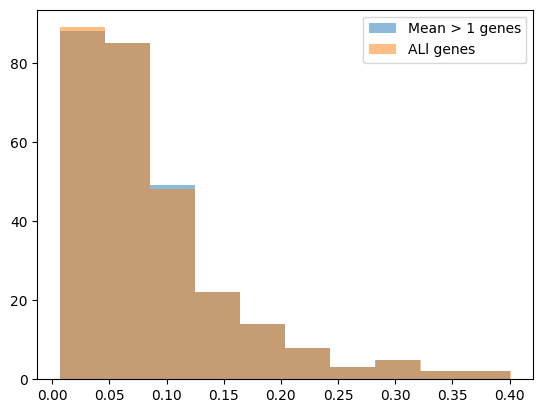

In [4]:
beta = estimate_capture(data_FIB)
beta_all = estimate_capture(data_all_FIB)
plt.hist(beta, alpha=0.5, label="Mean > 1 genes")
plt.hist(beta_all, alpha=0.5, label="ALl genes")
plt.legend()
plt.show()

4756 miRNA targets predicted
4419 are in the dataset (mean expr > 0)
2770 are in the dataset (mean expr > 1)


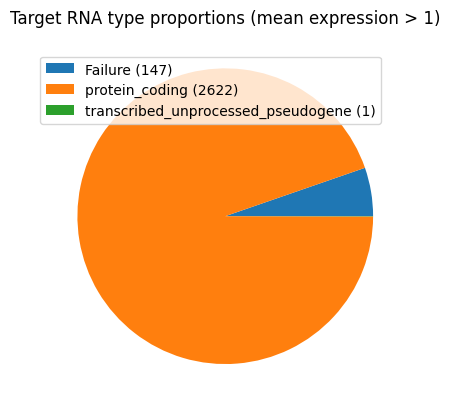

In [5]:
# load predicted targets
target_df = pd.read_csv("../../Real-Data/TargetScan/TargetScan8.0__miR-103a-2-5p.Human.predicted_targets.txt", delimiter="\t", index_col=0)

# display statistics
target_names = list(target_df.index)
gene_names_all = list(data_all_FIB.index)
gene_names_thresh = list(data_FIB.index)
shared_names_all = list(set(target_names) & set(gene_names_all))
shared_names_thresh = list(set(target_names) & set(gene_names_thresh))

print(f"{len(target_names)} miRNA targets predicted")
print(f"{len(shared_names_all)} are in the dataset (mean expr > 0)")
print(f"{len(shared_names_thresh)} are in the dataset (mean expr > 1)")

# target biotypes
target_biotypes = []
for i, btype in biotypes_dict.items():
    if gene_names_thresh[i] in target_names:
        target_biotypes.append(btype)

# display proportions of RNA types
counts = np.unique(target_biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(0,0.75), labels=[f"{name} ({count})" for name, count in zip(counts[0], counts[1])])
plt.title("Target RNA type proportions (mean expression > 1)")
plt.show()

In [26]:
def construct_dataset(mir_sample, mRNA_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mRNA_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mir_sample
        gene_j = mRNA_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [165]:
def reduce_dataset(dataset, selected_indices):

    # size
    cells = dataset.cells
    gene_pairs = len(selected_indices)

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # construct moment bounds dict
    moment_dict = {}

    # copy over selected data
    for i, j in enumerate(selected_indices):
        counts_df.iloc[i] = dataset.count_dataset.iloc[j]
        moment_dict[f'sample-{i}'] = dataset.moment_bounds[f'sample-{j}']

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = dataset.resamples

    # set capture
    data.beta = dataset.beta

    # set moments
    data.moment_bounds = moment_dict
    data.d = dataset.d

    return data

# Interacting models example

In [334]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[k:k+genes], beta)

# bootstrap
dataset_mir.bootstrap(d=4, tqdm_disable=False)

100%|██████████| 100/100 [00:04<00:00, 20.77it/s]


In [335]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

# test feasibility
opt_MF = optimization.ModelFreeOptimization(dataset_mir, d, constraints=constraints, printing=False, silent=True)
opt_MF.analyse_dataset()

100%|██████████| 100/100 [00:04<00:00, 22.52it/s]


In [336]:
selected_indices_mf = []
for i, mf_result in opt_MF.result_dict.items():
    if mf_result['status'] == "INFEASIBLE":
        selected_indices_mf.append(i)
dataset_mir_mf = reduce_dataset(dataset_mir, selected_indices_mf)

In [337]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
fixed = [(1, 1)]

# test feasibility
opt_BD = optimization.BirthDeathOptimization(dataset_mir_mf, d, constraints=constraints, silent=True, fixed=fixed)
opt_BD.analyse_dataset()

100%|██████████| 30/30 [00:02<00:00, 11.12it/s]


In [338]:
selected_indices_bd = []
for i, mf_result in opt_BD.result_dict.items():
    if mf_result['status'] == "INFEASIBLE":
        selected_indices_bd.append(i)
dataset_mir_bd = reduce_dataset(dataset_mir_mf, selected_indices_bd)

In [339]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    telegraph_moments=True,
    telegraph_moments_ineq=True,
    telegraph_factorization=False
)
fixed = [(3, 1)]#, (7, 1), (8, 0)]

# test feasibility
opt_TE = optimization.TelegraphOptimization(dataset_mir_bd, d, constraints=constraints, silent=True, fixed=fixed)
opt_TE.analyse_dataset()

100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


In [340]:
def text_map_mf(text):
    if text == "INFEASIBLE":
        return "DEPENDENT"
    elif text == "OPTIMAL":
        return "INDEPENDENT"
    else:
        return text

def text_map(text):
    if text == "OPTIMAL":
        return "FEASIBLE"
    else:
        return text

In [341]:
result_summary_int = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Int. Birth-Death", "Int. Telegraph"]
)

for i, MF_result in opt_MF.result_dict.items():
    result_summary_int.iloc[i, 0] = text_map_mf(MF_result['status'])
for i, BD_result in opt_BD.result_dict.items():
    j = selected_indices_mf[i]
    result_summary_int.iloc[j, 1] = text_map(BD_result['status'])
for i, TE_result in opt_TE.result_dict.items():
    j = selected_indices_bd[i]
    k = selected_indices_mf[j]
    result_summary_int.iloc[k, 2] = text_map(TE_result['status'])

result_summary_int.describe()

,Model free test,Int. Birth-Death,Int. Telegraph
count,100,30,30
unique,2,1,1
top,INDEPENDENT,INFEASIBLE,FEASIBLE
freq,70,30,30


# Independent models example

In [342]:
# genes
genes = 100
k = 0

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[k:k+genes], beta)

# bootstrap
dataset_mir.bootstrap(d=4, tqdm_disable=False)

100%|██████████| 100/100 [00:04<00:00, 23.04it/s]


In [343]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

# test feasibility
opt_MF = optimization.ModelFreeOptimization(dataset_mir, d, constraints=constraints, printing=False, silent=True)
opt_MF.analyse_dataset()

100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


In [344]:
selected_indices_mf = []
for i, mf_result in opt_MF.result_dict.items():
    if mf_result['status'] == "OPTIMAL":
        selected_indices_mf.append(i)
dataset_mir_mf = reduce_dataset(dataset_mir, selected_indices_mf)

In [345]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=True
)
fixed = [(1, 1), (3, 1), (4, 0)]

# test feasibility
opt_BD = optimization.BirthDeathOptimization(dataset_mir_mf, d, constraints=constraints, silent=True, fixed=fixed)
opt_BD.analyse_dataset()

100%|██████████| 69/69 [00:03<00:00, 17.74it/s]


In [346]:
selected_indices_bd = []
for i, mf_result in opt_BD.result_dict.items():
    if mf_result['status'] == "INFEASIBLE":
        selected_indices_bd.append(i)
dataset_mir_bd = reduce_dataset(dataset_mir_mf, selected_indices_bd)

In [347]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    telegraph_moments=True,
    telegraph_moments_ineq=True,
    telegraph_factorization=True
)
fixed = [(3, 1), (7, 1), (8, 0)]

# test feasibility
opt_TE = optimization.TelegraphOptimization(dataset_mir_bd, d, constraints=constraints, silent=True, fixed=fixed)
opt_TE.analyse_dataset()

100%|██████████| 69/69 [00:23<00:00,  2.94it/s]


In [348]:
result_summary_ind = pd.DataFrame(
    index=[f"Gene-pair-{i}" for i in range(genes)],
    columns=["Model free test", "Ind. Birth-Death", "Ind. Telegraph"]
)

for i, MF_result in opt_MF.result_dict.items():
    result_summary_ind.iloc[i, 0] = text_map_mf(MF_result['status'])
for i, BD_result in opt_BD.result_dict.items():
    j = selected_indices_mf[i]
    result_summary_ind.iloc[j, 1] = text_map(BD_result['status'])
for i, TE_result in opt_TE.result_dict.items():
    j = selected_indices_bd[i]
    k = selected_indices_mf[j]
    result_summary_ind.iloc[k, 2] = text_map(TE_result['status'])

result_summary_ind.describe()

,Model free test,Ind. Birth-Death,Ind. Telegraph
count,100,69,69
unique,2,1,2
top,INDEPENDENT,INFEASIBLE,INFEASIBLE
freq,69,69,36


# Combined example

In [289]:
# need better sankey function to plot in a combined diagram

# Sankey plots

In [278]:
import plotly
import plotly.graph_objects as go
import pandas as pd

In [279]:
def sankey_from_df(df):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])

    headers = ["Gene pairs"] + list(df.columns)
    for x_coordinate, column_name in enumerate(headers):
        fig.add_annotation(
                x=x_coordinate / (column_number),
                y=1.1,
                xref="paper",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="tomato"
                    ),
                align="center",
                )
        
    #fig.update_layout(font_size=15)
    fig.update_layout(
        title_text="Basic Sankey Diagram", 
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }, plot_bgcolor='rgba(0,0,0,0)', font_size=10
    )

    fig.show()

In [349]:
sankey_from_df(result_summary_int)

In [350]:
sankey_from_df(result_summary_ind)

# Birth-Death infeasibility inspection

In [357]:
# genes
genes = 1000
k = 0

data = construct_dataset(data_miRNA.loc["MIR103A2"], data_FIB[:genes], beta)
data.bootstrap(d=2, tqdm_disable=False)

means = []
variances = []

for s in range(genes):
    bounds = data.moment_bounds[f'sample-{s}']
    E_x = bounds[:, 2]
    E2_x = bounds[:, 5]
    V_x = E2_x - E_x**2
    means.append(np.mean(E_x))
    variances.append(np.mean(V_x))

100%|██████████| 1000/1000 [00:20<00:00, 49.87it/s]


Text(0.5, 1.0, 'Gene data overdispersed')

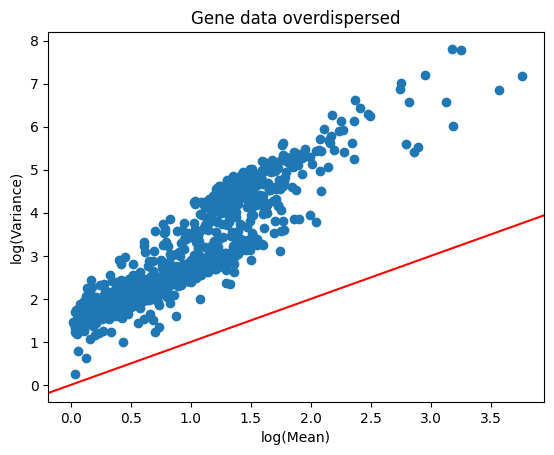

In [374]:
plt.scatter(np.log10(means), np.log10(variances), label="Gene counts")
plt.axline([0, 0], [1, 1], color="red", label="Poisson")
plt.xlabel("log(Mean)")
plt.ylabel("log(Variance)")
plt.title("Gene data overdispersed")